In [1]:
using DifferentialEquations
using Plots
using SymPy
using BenchmarkTools
using StaticArrays

(-c/(2*sqrt(c^2 - 4*k*m)) + 1/2)*exp(-t*(c + sqrt(c^2 - 4*k*m))/(2*m)) + (c/(2*sqrt(c^2 - 4*k*m)) + 1/2)*exp(t*(-c + sqrt(c^2 - 4*k*m))/(2*m))


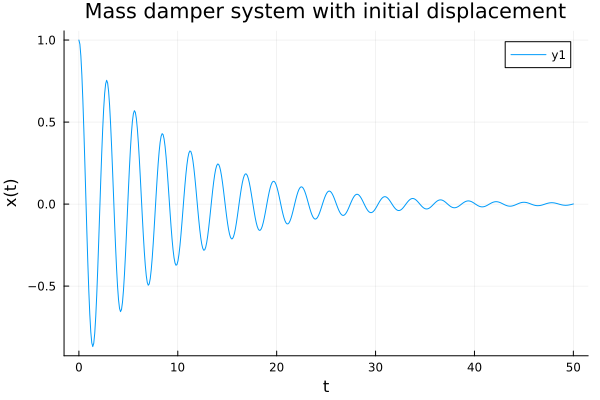

In [2]:
t = symbols("t")
x = SymFunction("x")(t)

m, c, k = symbols("m c k")

mass_damper = m * diff(x, t, 2) + c * diff(x, t) + k * x ~ 0

x_solution = dsolve(mass_damper, x)
x_general = rhs(x_solution)
x_prime = diff(x_general, t)

boundary_eq1 = x_general.subs(t,0) - 1
boundary_eq2 = x_prime.subs(t,0)

C1 = symbols("C1")
C2 = symbols("C2")
eqs = (boundary_eq1, boundary_eq2)
solution = solve([boundary_eq1, boundary_eq2], [C1, C2])
final_solution = x_general.subs(solution)


println(final_solution)

m_val = 1
c_val = 0.2
k_val = 5

numerical_solution = final_solution.subs((m => m_val, c => c_val, k => k_val))
t_domain = range(0, stop=50, length=500)

x_numeric = lambdify(numerical_solution, [t])

x_vals = x_numeric.(t_domain)

x_vals_plot = real(x_vals)

plot(t_domain, x_vals_plot, xlabel="t", ylabel="x(t)", title="Mass damper system with initial displacement", grid=true)

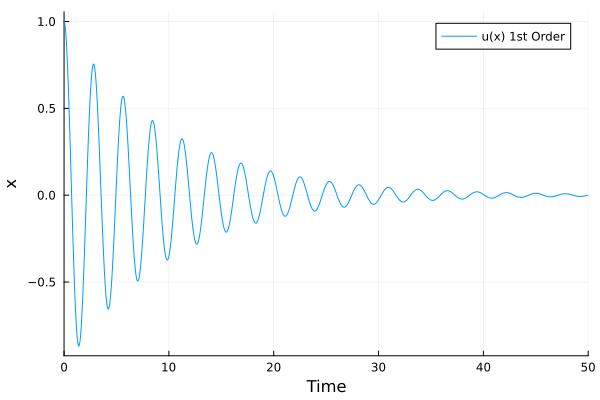

In [3]:
function mass_damper!(du, u, p, t)
    m, c, k = p
    du[1] = u[2]  
    du[2] = -(c/m) * u[2] - (k/m) * u[1]
    nothing
end

m = 1.0
c = 0.2
k = 5.0
p = (m, c, k)

u0 = [1.0, 0.0]

tspan = (0.0, 50.0)
t_domain = range(0, stop=50, length=500)

prob = ODEProblem(mass_damper!, u0, tspan, p)

sol1 = solve(prob, Vern7(), abstol = 1e-8, reltol = 1e-8)
plot(sol1, idxs=1, label="u(x) 1st Order", xlabel="Time", ylabel="x")
#plot(sol1[1,:])

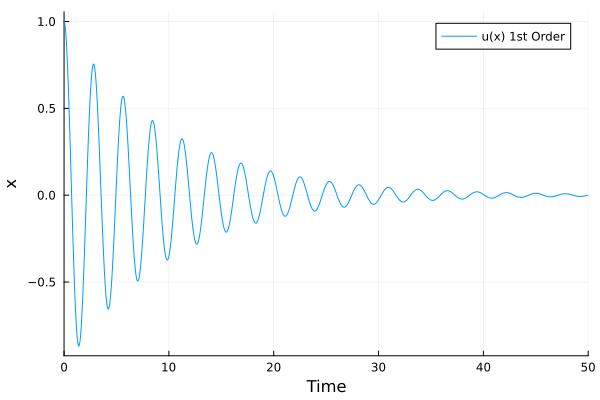

In [4]:
function mass_damperSA(u, p, t)
    m, c, k = p
    du1 = u[2]  
    du2 = -(c/m) * u[2] - (k/m) * u[1]
    return SA[du1, du2]
end

m = 1.0
c = 0.2
k = 5.0
p = (m, c, k)

u0SA = SA[1.0, 0.0]

tspan = (0.0, 50.0)
t_domain = range(0, stop=50, length=500)

probSA = ODEProblem(mass_damperSA, u0SA, tspan, p)

sol1SA = solve(probSA, Vern7(), abstol = 1e-8, reltol = 1e-8)
plot(sol1SA, idxs=1, label="u(x) 1st Order", xlabel="Time", ylabel="x")
#plot(sol1[1,:])

In [5]:
du = [0.0, 0.0]
@benchmark mass_damper!(du,u0, p, tspan)

BenchmarkTools.Trial: 10000 samples with 998 evaluations.
 Range (min … max):  16.733 ns … 104.309 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     17.234 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   17.912 ns ±   2.689 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁█▅▁                                                          
  ████▃▂▂▃▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▂▂▂▁▂▂ ▃
  16.7 ns         Histogram: frequency by time         30.6 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [6]:
@benchmark sol1 = solve(prob, Vern7(), abstol = 1e-8, reltol = 1e-8)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  179.200 μs …  37.440 ms  ┊ GC (min … max):  0.00% … 99.28%
 Time  (median):     219.500 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   276.292 μs ± 854.321 μs  ┊ GC (mean ± σ):  13.39% ±  4.97%

   █▁                                                            
  ▆██▅▅▅▃▃▄▄▃▅▄▃▃▂▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  179 μs           Histogram: frequency by time          462 μs <

 Memory estimate: 360.98 KiB, allocs estimate: 8101.

In [7]:
@benchmark sol1SA = solve(probSA, Vern7(), abstol = 1e-8, reltol = 1e-8)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  48.800 μs …  39.373 ms  ┊ GC (min … max):  0.00% … 99.73%
 Time  (median):     66.800 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   82.825 μs ± 540.046 μs  ┊ GC (mean ± σ):  12.43% ±  1.99%

  ▆▆▄▃▂▂▂▆█▇▆▅▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁ ▁▁ ▁                        ▂
  ███████████████████████████████████████▇▇▇▇▆▆▆▇▆▇▅▆▅▅▆▆▅▆▃▄▅ █
  48.8 μs       Histogram: log(frequency) by time       166 μs <

 Memory estimate: 105.19 KiB, allocs estimate: 703.

In [8]:
@benchmark sol1 = solve(prob, Vern7())

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  54.100 μs …  39.802 ms  ┊ GC (min … max):  0.00% … 99.63%
 Time  (median):     76.400 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   88.092 μs ± 593.442 μs  ┊ GC (mean ± σ):  11.56% ±  1.72%

   █         ▃   ▁▄▂                                            
  ▇█▇▄▆▇▅▃▃▃▇█▇▄▅███▇▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  54.1 μs         Histogram: frequency by time          148 μs <

 Memory estimate: 108.92 KiB, allocs estimate: 2452.

In [9]:
@benchmark sol1 = solve(prob, Tsit5())

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  58.100 μs …  38.679 ms  ┊ GC (min … max):  0.00% … 99.69%
 Time  (median):     78.400 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   90.581 μs ± 581.489 μs  ┊ GC (mean ± σ):  11.02% ±  1.72%

   █                                                            
  ▅██▃▃▃▂▂▁▂▃▆▅▄▄▄▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  58.1 μs         Histogram: frequency by time          154 μs <

 Memory estimate: 113.92 KiB, allocs estimate: 2628.

In [10]:
plot(t_domain, x_vals_plot, label="Analytical Solution", xlabel="t", ylabel="x(t)", title="Compare anaylitcal and numerical solution 1st Order", grid=true)
plot!(t_domain, sol1[1,:], label="Numerical Solution", linestyle=:dash)


In [11]:
x_vals = x_numeric.(sol1.t)
x_vals_plot = real(x_vals)

335-element Vector{Float64}:
  1.0
  0.9975844285951672
  0.9838656263224749
  0.9525776498033693
  0.8969068483804677
  0.8110671350366734
  0.6907316446213144
  0.5354156013231481
  0.3495153775702173
  0.14242716941192196
  ⋮
  0.0022819329130838416
 -0.0014758703398248978
 -0.0046875688856779065
 -0.006722299856089248
 -0.00726444729574142
 -0.006287196714245104
 -0.004012104219855648
 -0.0008773504588208705
  0.0008091903411163762

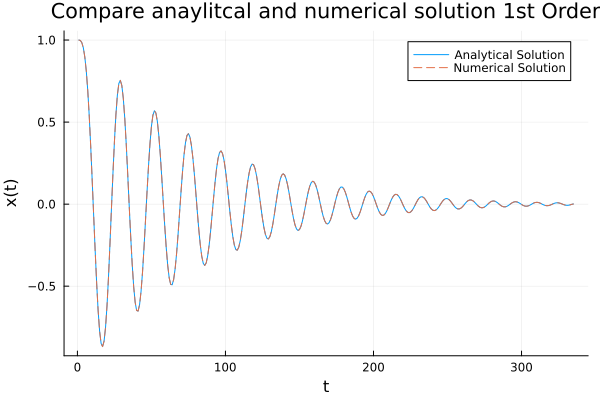

In [12]:
plot( x_vals_plot, label="Analytical Solution", xlabel="t", ylabel="x(t)", title="Compare anaylitcal and numerical solution 1st Order", grid=true)
plot!( sol1[1,:], label="Numerical Solution", linestyle=:dash)

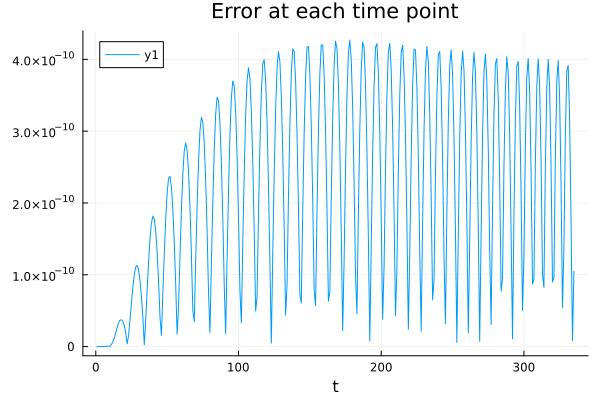

In [13]:
e1 = x_vals_plot - sol1[1,:]
plot(abs.(e1), xlabel = "t", title = "Error at each time point")

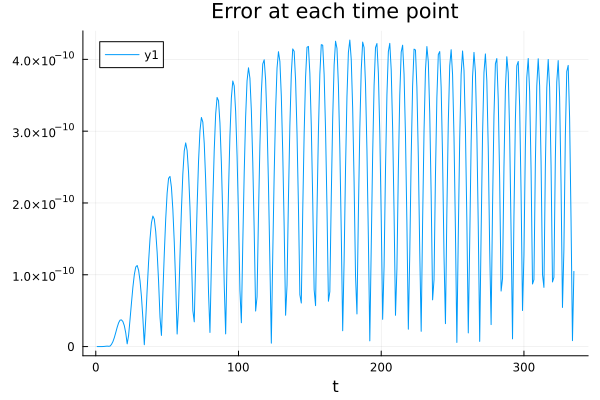

In [14]:
sol1SA = solve(probSA, Vern7(), abstol = 1e-8, reltol = 1e-8)
x_vals = x_numeric.(sol1SA.t)
x_vals_plot = real(x_vals)
e1SA = x_vals_plot - sol1SA[1,:]
plot(abs.(e1SA), xlabel = "t", title = "Error at each time point")

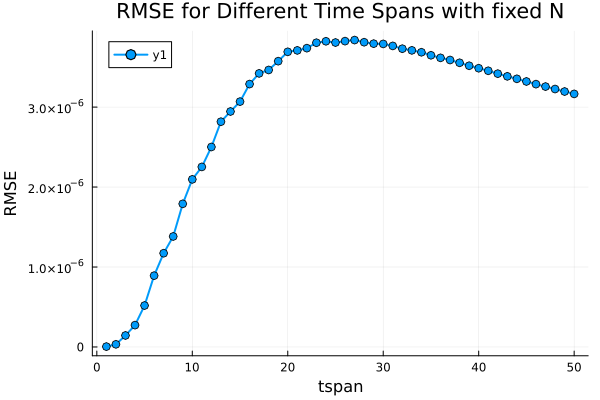

In [15]:
timeSpans = range(1,50,step = 1)
errors = Float64[]

for ts in timeSpans
    tspan = (0.0, ts)
    t_domain = range(0,stop = ts, length = 500)
    prob = ODEProblem(mass_damper!, u0, tspan, p)
    sol = solve(prob, Vern9(), saveat=t_domain)

    x_vals_analytical = [x_numeric(ti) for ti in t_domain]

    x_vals_numerical = sol[1,:]

    rmse = sqrt(sum((x_vals_analytical-x_vals_numerical).^2)/500)
    push!(errors, rmse)
end
plot(timeSpans, errors, xlabel="tspan", ylabel="RMSE", title="RMSE for Different Time Spans with fixed N", lw=2, marker=:o)


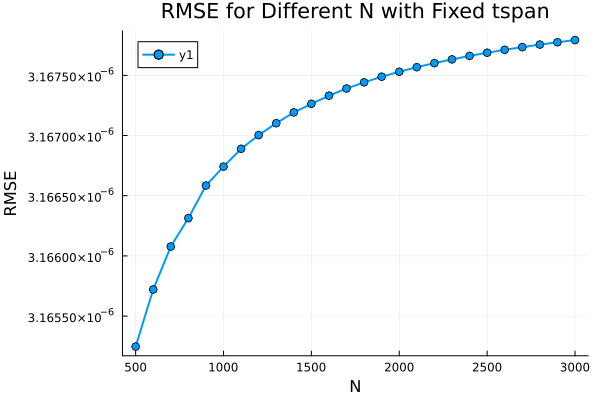

In [16]:
Nvals = range(500, 3000, step=100)
errors = Float64[]

for N in Nvals
    tspan = (0.0, 50.0)
    t_domain = range(0, stop=50, length=N)
    prob = ODEProblem(mass_damper!, u0, tspan, p)
    sol = solve(prob, Vern9(), saveat=t_domain)

    x_vals_analytical = [x_numeric(ti) for ti in t_domain]

    x_vals_numerical = sol[1,:]

    rmse = sqrt(sum((x_vals_analytical .- x_vals_numerical).^2) / N)
    push!(errors, rmse)
end

plot(Nvals, errors, xlabel="N", ylabel="RMSE", title="RMSE for Different N with Fixed tspan", lw=2, marker=:o)

In [43]:
function mass_damper2!(ddu::Vector{Float64}, du::Vector{Float64}, u::Vector{Float64}, p::Tuple{Float64, Float64, Float64}, t::Float64)
    m, c, k = p
    ddu[1] = -(c/m) * du[1] - (k/m) * u[1]
    nothing
end

mass_damper2! (generic function with 1 method)

In [53]:
ddu = [0.0]
du = [1.0]
u = [1.0]
p = (1.0, 0.1, 0.5)
t = 0.0

# Benchmark the function
@benchmark mass_damper2!($ddu, $du, $u, $p, $t)


BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  2.300 ns … 82.800 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.500 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.575 ns ±  1.305 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █ ▅  ▇ ▆  ▁  ▅                         ▁  ▁ ▁  ▁           ▂
  █▁█▁▁█▁█▁▁█▁▁█▁█▁▁▆▁▁▅▁▃▁▁▆▁▅▁▁▄▁▁▇▁█▁▁█▁▁█▁█▁▁█▁▁█▁█▁▁█▁▆ █
  2.3 ns       Histogram: log(frequency) by time      4.5 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [50]:
m = 1.0
c = 0.2
k = 5.0
p = (m, c, k)

u0 = [1.0, 0.0]  # u[1] = x, du[1] = v
du0 = [0.0]
tspan = (0.0, 50.0)
t_domain = range(0, stop=50, length=500)

prob = SecondOrderODEProblem(mass_damper2!, du0, u0, tspan, p)
sol2 = solve(prob, VerletLeapfrog(),dt = 0.01)
#@btime sol2 = solve(prob, Vern9(), saveat=t_domain)
#@btime sol2 = solve(prob, Vern9(), saveat=t_domain)
#plot(sol2[2,:])

retcode: Success
Interpolation: 3rd order Hermite
t: 5002-element Vector{Float64}:
  0.0
  0.01
  0.02
  0.03
  0.04
  0.05
  0.060000000000000005
  0.07
  0.08
  0.09
  ⋮
 49.929999999998635
 49.93999999999863
 49.94999999999863
 49.95999999999863
 49.96999999999863
 49.979999999998626
 49.98999999999862
 49.99999999999862
 50.0
u: 5002-element Vector{ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}}:
 ([0.0], [1.0, 0.0])
 ([-0.049968750000000006], [0.99975, -0.00025])
 ([-0.09981264058593751], [0.9990008746875, -0.0009991253125])
 ([-0.1495070118674609], [0.9977539961893745, -0.002246003810625391])
 ([-0.19902732797161174], [0.9960109826417712, -0.003989017358228669])
 ([-0.24834918905671657], [0.9937736968896744, -0.006226303110325513])
 ([-0.2974483432342812], [0.9910442450667755, -0.00895575493322453])
 ([-0.34630069839311356], [0.9878249750565983, -0.012175024943401693])
 ([-0.3948823339199614], [0.9841184748358869, -0.015881525164113047])
 ([-0.44316951231101465]

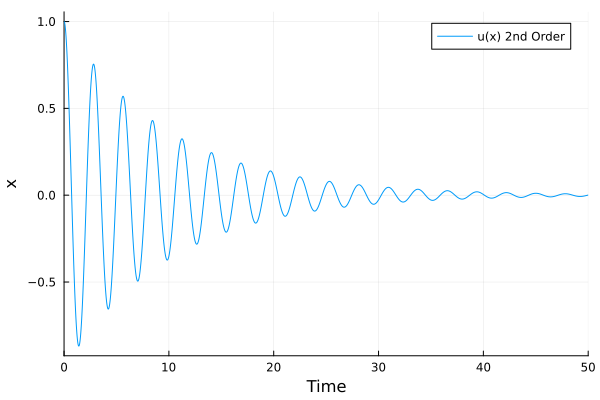

In [19]:
function mass_damper2SA(du, u, p, t)
    m, c, k = p
    ddu1 = -(c/m) * du[1] - (k/m) * u[1]
    return SA[ddu1]
end
m = 1.0
c = 0.2
k = 5.0
p = (m, c, k)

u0SA = SA[1.0]  # u[1] = x, du[1] = v
du0SA = SA[0.0]
tspan = (0.0, 50.0)
t_domain = range(0, stop=50, length=500)

probSA = SecondOrderODEProblem(mass_damper2SA, du0SA, u0SA, tspan, p)
sol2SA = solve(probSA, Vern7(),abstol = 1e-8, reltol = 1e-8)
#@btime sol2 = solve(prob, Vern9(), saveat=t_domain)
#@btime sol2 = solve(prob, Vern9(), saveat=t_domain)
plot(sol2SA, idxs=2, label="u(x) 2nd Order", xlabel="Time", ylabel="x")
#plot(sol2[2,:])


In [52]:
@benchmark sol2 = solve(prob, Vern7(),abstol = 1e-8, reltol = 1e-8)

BenchmarkTools.Trial: 5745 samples with 1 evaluation.
 Range (min … max):  553.200 μs … 66.117 ms  ┊ GC (min … max): 0.00% … 98.73%
 Time  (median):     661.800 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   862.270 μs ±  1.813 ms  ┊ GC (mean ± σ):  9.09% ±  4.63%

  █▇▇▆▅▅▅▅▅▄▄▃▂▂▁▂▁▁▁  ▁                                       ▂
  ████████████████████████▆▇▇▅▇▆▇███▇▇▆▆▇▆▆▆▆▃▂▄▄▄▂▆▅▄▄▄▃▄▂▄▂▄ █
  553 μs        Histogram: log(frequency) by time      2.35 ms <

 Memory estimate: 673.00 KiB, allocs estimate: 18542.

In [21]:
@benchmark sol2NoTol = solve(prob, Vern7())


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  168.000 μs … 88.553 ms  ┊ GC (min … max):  0.00% … 99.65%
 Time  (median):     191.400 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   230.788 μs ±  1.155 ms  ┊ GC (mean ± σ):  10.20% ±  2.22%

  █▇▅▅▄▄▃▃▃▃▄▆▆▅▄▄▃▃▃▃▂▂▂▂▁▁▁ ▁▁  ▁▁▁                          ▂
  █████████████████████████████████████▇██▇▇▇▇▆▆▆▆▄▅▆▆▅▁▄▆▅▄▅▄ █
  168 μs        Histogram: log(frequency) by time       412 μs <

 Memory estimate: 204.75 KiB, allocs estimate: 5654.

In [42]:
@benchmark sol2SA = solve(probSA, Vern7(),abstol = 1e-8, reltol = 1e-8)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  54.600 μs …  43.448 ms  ┊ GC (min … max):  0.00% … 99.24%
 Time  (median):     80.000 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   99.981 μs ± 640.015 μs  ┊ GC (mean ± σ):  10.70% ±  1.72%

  ▂     ▄▇█▃                                                    
  █▅▄▂▃▇████▆▄▄▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  54.6 μs         Histogram: frequency by time          231 μs <

 Memory estimate: 105.19 KiB, allocs estimate: 703.

In [36]:
x_vals = x_numeric.(sol2.t)
x_vals_plot = real(x_vals)

5002-element Vector{Float64}:
  1.0
  0.9997501769915307
  0.9990014983902407
  0.9977553348598984
  0.9960133028092185
  0.9937772630934995
  0.9910493195967607
  0.987831817695323
  0.9841273426038402
  0.9799387176048391
  ⋮
 -0.00024516856392049405
 -9.340200291508706e-5
  5.8107980686853235e-5
  0.00020928622339338093
  0.0003600578775868024
  0.0005103484482779875
  0.0006600838296101543
  0.0008091903410959339
  0.0008091903411163762

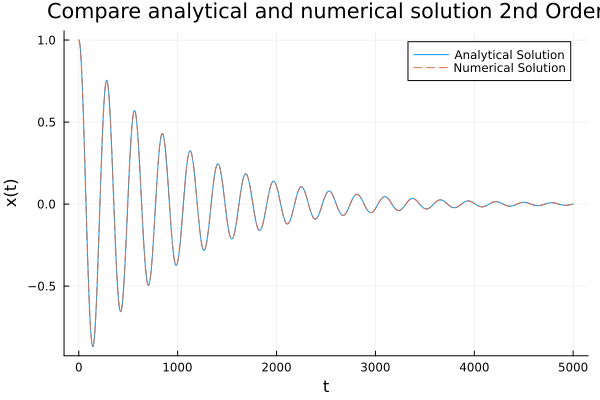

In [37]:
plot(x_vals_plot, label="Analytical Solution", xlabel="t", ylabel="x(t)", title="Compare analytical and numerical solution 2nd Order", grid=true)
plot!(sol2[2,:], label="Numerical Solution", linestyle=:dash)


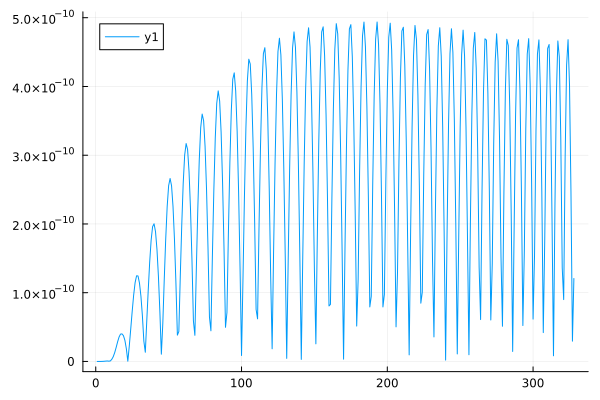

In [25]:
e2 = x_vals_plot - sol2[2,:]
plot(abs.(e2))

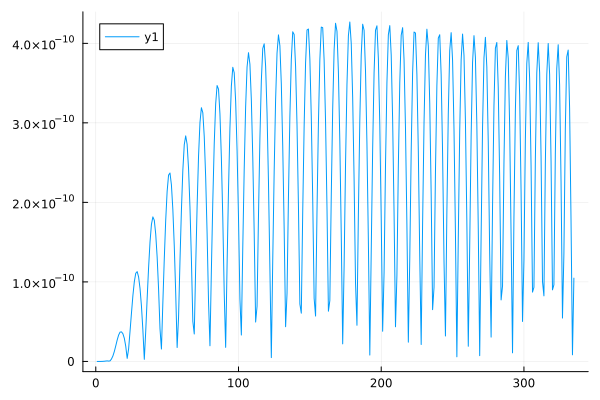

In [26]:
sol2SA = solve(probSA, Vern7(),abstol = 1e-8, reltol = 1e-8)

x_vals = x_numeric.(sol2SA.t)
x_vals_plot = real(x_vals)
e2SA = x_vals_plot - sol2SA[2,:]
plot(abs.(e2SA))

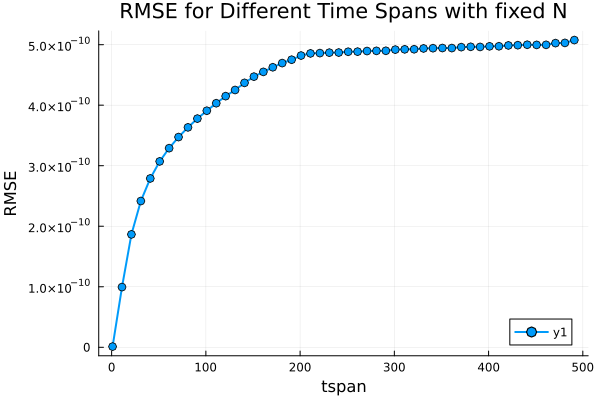

In [27]:
timeSpans = range(1,500,step = 10)
errors = Float64[]

for ts in timeSpans
    tspan = (0.0, ts)
    t_domain = range(0,stop = ts, length = 500)
    prob = SecondOrderODEProblem(mass_damper2!, du0, u0, tspan, p)
    sol = solve(prob, Vern7(), abstol = 1e-8, reltol = 1e-8)

    x_vals_analytical = x_numeric.(sol.t)
    x_vals_numerical = sol[2,:]
    rmse = sqrt(sum((x_vals_analytical-x_vals_numerical).^2)/length(sol2.t))
    push!(errors, rmse)
end
plot(timeSpans, errors, xlabel="tspan", ylabel="RMSE", title="RMSE for Different Time Spans with fixed N", lw=2, marker=:o)


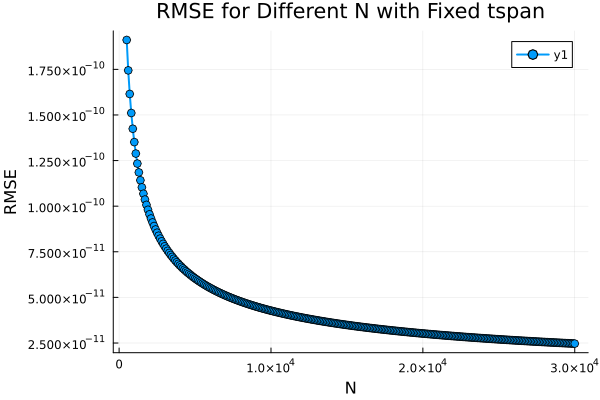

In [28]:
Nvals = range(500, 30000, step=100)
errors = Float64[]

for N in Nvals
    tspan = (0.0, 30.0)
    t_domain = range(0, stop=30, length=N)
    prob = SecondOrderODEProblem(mass_damper2!, du0, u0, tspan, p)
    sol = solve(prob, Vern7(), abstol = 1e-8, reltol = 1e-8)

    x_vals_analytical = x_numeric.(sol.t)

    x_vals_numerical = sol[2,:]

    rmse = sqrt(sum((x_vals_analytical .- x_vals_numerical).^2) / N)
    push!(errors, rmse)
end

plot(Nvals, errors, xlabel="N", ylabel="RMSE", title="RMSE for Different N with Fixed tspan", lw=2, marker=:o)

(-c/(2*sqrt(c^2 - 4*k*m)) + 1/2)*exp(-t*(c + sqrt(c^2 - 4*k*m))/(2*m)) + (c/(2*sqrt(c^2 - 4*k*m)) + 1/2)*exp(t*(-c + sqrt(c^2 - 4*k*m))/(2*m))


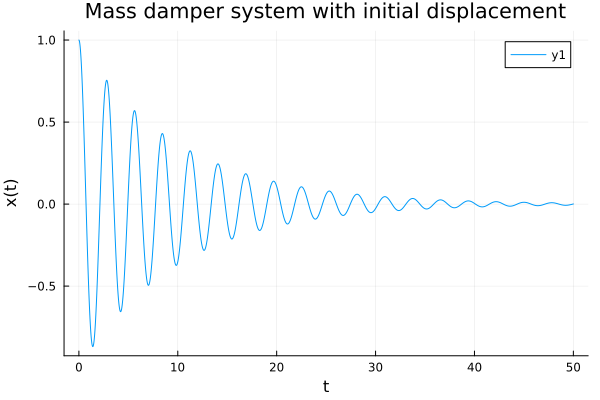

In [29]:
t = symbols("t")
x = SymFunction("x")(t)

m, c, k = symbols("m c k")

mass_damper = m * diff(x, t, 2) + c * diff(x, t) + k * x ~ 0

x_solution = dsolve(mass_damper, x)
x_general = rhs(x_solution)
x_prime = diff(x_general, t)

boundary_eq1 = x_general.subs(t,0) - 1
boundary_eq2 = x_prime.subs(t,0)

C1 = symbols("C1")
C2 = symbols("C2")
eqs = (boundary_eq1, boundary_eq2)
solution = solve([boundary_eq1, boundary_eq2], [C1, C2])
final_solution = x_general.subs(solution)


println(final_solution)

m_val = 1
c_val = 0.2
k_val = 5

numerical_solution = final_solution.subs((m => m_val, c => c_val, k => k_val))
t_domain = range(0, stop=50, length=5000)

x_numeric = lambdify(numerical_solution, [t])

x_vals = x_numeric.(t_domain)

x_vals_plot = real(x_vals)

plot(t_domain, x_vals_plot, xlabel="t", ylabel="x(t)", title="Mass damper system with initial displacement", grid=true)

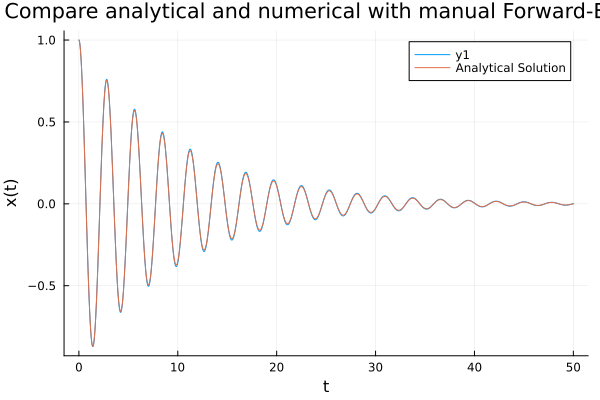

In [30]:
m = 1
c = 0.2
k = 5
tmax = 50.0
t0 = 0.0
Δt = 0.001

#IC's
x0 = 1.0
v0 = 0.0

#System matrix
A = [0.0 1.0;-k/m -c/m]
u = [x0;v0]

#Lists for Graphing
displacement = [x0]
velocity = [v0]
time = [t0]

#Loop
t = t0
while t <= tmax
	global t,u

	uprime = A * u
	u_2 = u + Δt* uprime
	t += Δt
	push!(displacement,u_2[1])
	push!(velocity,u_2[2])
	push!(time,t)
	#println(time)	
	u = u_2
end


plot(time,displacement, xlabel = "time [s]", ylabel = "displacement [m]",title = "Mass spring damper system solution")
plot!(t_domain, x_vals_plot, label="Analytical Solution", xlabel="t", ylabel="x(t)", title="Compare analytical and numerical with manual Forward-Euler", grid=true)